<a href="https://colab.research.google.com/github/oliverwsd/Deep-Portfolio/blob/master/LTSM_50_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from keras.layers import Input, Dense, Dropout,LSTM
from keras.models import Model
from keras.models import Sequential
from keras import regularizers
from keras.constraints import maxnorm
from keras.models import load_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

matplotlib.rcParams[ 'figure.figsize' ] = ( 20, 6 )


#packages for modelling
import tensorflow.compat.v1 as tfo
import tensorflow as tf
import random as rd
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal

#packages for plotting
%matplotlib inline
import matplotlib.dates as md
import pydot

#packages for extraction and saving data
import os
import glob as glob
import csv

#packages for date handling
import datetime
from time import time

In [12]:
# preparing data for LSTMs
# we consider an embedding layer instead of feeding the entire seires into the model at once
# therefore we split data into smaller peices in an constant window to create a smaller seires of observertion for prediction

def normalize_data(X, Y, LOOKBACK_WINDOW):
    _X = X.dropna()
    _Xs = []
    _Ys = []
    for i in range(_X.shape[0] - LOOKBACK_WINDOW):
        cur_X = _X.values[i:i + LOOKBACK_WINDOW]
        _Xs.append(cur_X)
        
        y_pointer = i + LOOKBACK_WINDOW
        cur_Y = Y.values[y_pointer]
        _Ys.append(cur_Y)
    return np.array(_Xs), np.array(_Ys)

In [10]:
from io import StringIO
import csv
# realized variance 
x_data = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/sp500_stock_selected.csv'
y_data = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/sp500_index_rv.csv'
# read csv
stock_data = pd.read_csv(x_data,index_col=0)
index_data = pd.read_csv(y_data, index_col=0)

In [40]:
# x: volatilities of selected 50 stocks in the last 100 days
# y: market volatility in 101th day 
x, y = normalize_data(stock_data, index_data, 200)

# Split the data into a training and test set
# We are using 80 percent of the data as training set and 20% as the test set. 
train_size  = int(len(x) * 0.80)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [41]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

nsamples, nx, ny = x_train.shape
d2_x_train = x_train.reshape((nsamples,nx*ny))
d2_x_train_scaled = sc.fit_transform(d2_x_train)
x_train_scaled = d2_x_train_scaled.reshape(nsamples,nx,ny)
x_train_scaled.shape

nsamples, nx, ny = x_test.shape
d2_x_test = x_test.reshape((nsamples,nx*ny))
d2_x_test_scaled = sc.fit_transform(d2_x_test)
x_test_scaled = d2_x_test_scaled.reshape(nsamples,nx,ny)
x_test_scaled.shape

y_train_scaled = sc.fit_transform(y_train)
y_train_scaled.shape

(729, 1)

In [42]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200, 128)          91648     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 200, 64)           49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [43]:
model.fit(x_train_scaled, y_train_scaled, epochs = 500, batch_size = 16)

Epoch 1/500
46/46 [==============================] - 15s 316ms/step - loss: 0.0059
Epoch 2/500
46/46 [==============================] - 15s 318ms/step - loss: 0.0056
Epoch 3/500
46/46 [==============================] - 15s 320ms/step - loss: 0.0054
Epoch 4/500
46/46 [==============================] - 15s 329ms/step - loss: 0.0053
Epoch 5/500
46/46 [==============================] - 15s 335ms/step - loss: 0.0053
Epoch 6/500
46/46 [==============================] - 15s 324ms/step - loss: 0.0052
Epoch 7/500
46/46 [==============================] - 15s 324ms/step - loss: 0.0052
Epoch 8/500
46/46 [==============================] - 15s 324ms/step - loss: 0.0051
Epoch 9/500
46/46 [==============================] - 16s 341ms/step - loss: 0.0049
Epoch 10/500
46/46 [==============================] - 15s 325ms/step - loss: 0.0049
Epoch 11/500
46/46 [==============================] - 15s 332ms/step - loss: 0.0051
Epoch 12/500
46/46 [==============================] - 15s 334ms/step - loss: 0.0047
E

In [45]:
model.save('ltsm_50.h5')

In [59]:
predictions = model.predict(x_test_scaled)
predictions = sc.inverse_transform(predictions)

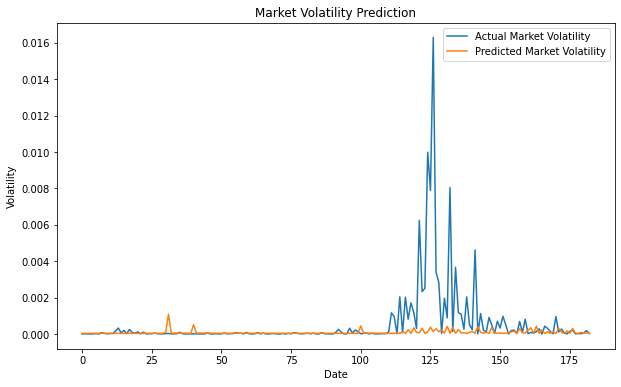

In [62]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Market Volatility')
plt.plot(predictions, label='Predicted Market Volatility')
plt.title('Market Volatility Prediction')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()